In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Data prepocecing

In [ ]:
dataset_2 = '/content/drive/MyDrive/CSE4238/Dataset_2.zip'
with ZipFile(dataset_2, 'r') as zip:
  zip.extractall()

In [ ]:
df_train = pd.read_csv('/content/Dataset_2/verification_train.csv')
df_test = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [ ]:
X_train = df_train.drop("label", axis=1).values.astype(np.uint8)
y_train = df_train["label"].values

X_test = df_test.drop("label", axis=1).values.astype(np.uint8)
y_test = df_test["label"].values

In [ ]:
class DigitsDataset(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = np.reshape(self.X[idx], (28, 28, 1))
        if self.transforms is not None:
            X = self.transforms(X)
        if self.y is not None:
            return X, self.y[idx]
        else:
            return X

In [ ]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [ ]:
train_data = DigitsDataset(X=X_train, y=y_train, transforms=transform_train)
test_data = DigitsDataset(X=X_test, y=y_test, transforms=transform_test)

## Base HyperParam

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:3000
Test dataloader:500


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.296325922012329. Accuracy: 10.0
Iteration: 1000. Loss: 2.2740139961242676. Accuracy: 19.56
Iteration: 1500. Loss: 2.101510763168335. Accuracy: 21.64
Iteration: 2000. Loss: 1.3044039011001587. Accuracy: 44.13
Iteration: 2500. Loss: 1.2167963981628418. Accuracy: 59.39
Iteration: 3000. Loss: 0.6099315881729126. Accuracy: 66.67
Epoch:  2
Iteration: 3500. Loss: 1.0396316051483154. Accuracy: 71.38
Iteration: 4000. Loss: 1.080285668373108. Accuracy: 75.58
Iteration: 4500. Loss: 0.566938042640686. Accuracy: 76.85
Iteration: 5000. Loss: 0.7182084321975708. Accuracy: 74.71
Iteration: 5500. Loss: 0.9519540667533875. Accuracy: 76.08
Iteration: 6000. Loss: 0.6155549883842468. Accuracy: 79.04
Epoch:  3
Iteration: 6500. Loss: 0.8964263200759888. Accuracy: 81.02
Iteration: 7000. Loss: 0.8999016880989075. Accuracy: 81.26
Iteration: 7500. Loss: 0.31626957654953003. Accuracy: 81.72
Iteration: 8000. Loss: 0.5686392188072205. Accuracy: 78.52
Iteration: 8500. Loss: 0.804227

[2.296325922012329, 2.2740139961242676, 2.101510763168335, 1.3044039011001587, 1.2167963981628418, 0.6099315881729126, 1.0396316051483154, 1.080285668373108, 0.566938042640686, 0.7182084321975708, 0.9519540667533875, 0.6155549883842468, 0.8964263200759888, 0.8999016880989075, 0.31626957654953003, 0.5686392188072205, 0.8042274713516235, 0.48104652762413025, 0.7921466827392578, 0.7275529503822327, 0.21569974720478058, 0.5236932039260864, 0.6758466958999634, 0.2907000780105591, 0.7342185974121094, 0.5875762104988098, 0.21737214922904968, 0.4613417685031891, 0.5844006538391113, 0.2660221755504608, 0.6864287853240967, 0.4971272349357605, 0.20470209419727325, 0.42735999822616577, 0.5213355422019958, 0.2455364465713501]


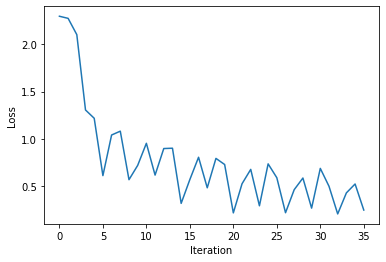

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## Exp 2 hyper parameter

In [ ]:
batch_size = 150
num_iters = 28000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.005

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

70


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:400
Test dataloader:67


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.softmax1 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)

        out  = self.linear_2(out)
        out = self.softmax1(out)
        
        out  = self.linear_3(out)
        out = self.relu_2(out)
 
        out  = self.linear_4(out)
        out = self.relu_3(out)

        
 
        
        probas  = self.linear_out(out)
        return probas


In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (softmax1): Softmax(dim=0)
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Iteration: 500. Loss: 0.5389787554740906. Accuracy: 83.92
Epoch:  3
Iteration: 1000. Loss: 0.3615964353084564. Accuracy: 85.59
Epoch:  4
Iteration: 1500. Loss: 0.42291492223739624. Accuracy: 85.6
Epoch:  5
Iteration: 2000. Loss: 0.3009078800678253. Accuracy: 85.59
Epoch:  6
Epoch:  7
Iteration: 2500. Loss: 0.4050148129463196. Accuracy: 85.71
Epoch:  8
Iteration: 3000. Loss: 0.37118595838546753. Accuracy: 86.25
Epoch:  9
Iteration: 3500. Loss: 0.3904319703578949. Accuracy: 85.85
Epoch:  10
Iteration: 4000. Loss: 0.32148873805999756. Accuracy: 86.38
Epoch:  11
Epoch:  12
Iteration: 4500. Loss: 0.4102630913257599. Accuracy: 85.75
Epoch:  13
Iteration: 5000. Loss: 0.29493963718414307. Accuracy: 86.6
Epoch:  14
Iteration: 5500. Loss: 0.3335580825805664. Accuracy: 86.25
Epoch:  15
Iteration: 6000. Loss: 0.3543508052825928. Accuracy: 86.16
Epoch:  16
Epoch:  17
Iteration: 6500. Loss: 0.46065887808799744. Accuracy: 86.5
Epoch:  18
Iteration: 7000. Loss: 0.2607938349246979. 

[0.5389787554740906, 0.3615964353084564, 0.42291492223739624, 0.3009078800678253, 0.4050148129463196, 0.37118595838546753, 0.3904319703578949, 0.32148873805999756, 0.4102630913257599, 0.29493963718414307, 0.3335580825805664, 0.3543508052825928, 0.46065887808799744, 0.2607938349246979, 0.38235774636268616, 0.22367507219314575, 0.3226235508918762, 0.33743831515312195, 0.43147701025009155, 0.18145953118801117, 0.2957000732421875, 0.27705687284469604, 0.3070594072341919, 0.31033697724342346, 0.37565746903419495, 0.2659919261932373, 0.33569321036338806, 0.21433542668819427, 0.2756637930870056, 0.2775881588459015, 0.2691574990749359, 0.3032541871070862, 0.3661595284938812, 0.27097636461257935, 0.30812549591064453, 0.22648081183433533, 0.29668667912483215, 0.24963226914405823, 0.30306610465049744, 0.20249414443969727, 0.274117648601532, 0.30678606033325195, 0.3322153687477112, 0.2587164342403412, 0.2892252206802368, 0.3104448914527893, 0.3563773036003113, 0.27971935272216797, 0.32086488604545

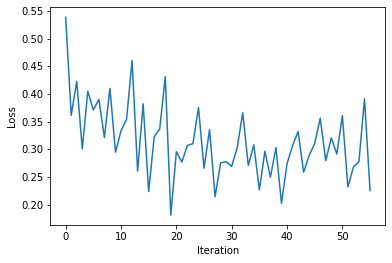

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()